# This notebook trains the models with adding extra features from the course-level processed data - course_level_processed_combined.csv

Integrating course-level (program data) to our previous model ("ML_models_insttitte_level_only.ipynb") seems like a good idea but mainly because:


Two universities might look the same at institution-level (ENG_RATIO, cost, retention), but one has more engineering programs or lower typical debt in those programs. Course-level file already contains that (DEBT_* fields by CIP, etc.). That’s extra signal current model doesn’t see.

Our initial idea - explicitly talks about “Which stream at this college is the best fit?” and program-level outcomes (debt, earnings). 

Even if the ROC AUC only improves a bit, being able to say “this college has 8 engineering majors with relatively low debt” is a big win for the product.

For pure VALUE_LABEL prediction (affordable + good quality), course-level aggregates might give a modest metric bump, because QUALITY_SCORE and COSTT4_A already encode a lot. But they’re definitely useful as extra features and for the final ranking and explanation layer.

Incorporating location filter in the same notebook - (location_filter.ipynb)
This is done caring less about improving ROC AUC and more about:
Hard constraints (“I only want colleges within 200 km of home”).
A weighted objective (“location = 4/5 importance”).

How course level + location filter gets incorpoprated in the notebook - high level understanding :



Augment institution-level X with course aggregates
From course_level_processed_combined.csv (already engineering-only), build per-UNITID features like:

ENG_PROG_COUNT = number of distinct engineering programs (CIPCODE nunique).

ENG_CRED_LEVELS = number of different credential levels (bachelor, master, etc.).

DEBT_ALL_STGP_ANY_MDN_mean/min/max = typical program-level debt stats for engineering.
Then merge onto the inst_df and include them as features in the VALUE_LABEL classifier.

Keep VALUE_LABEL definition as institution-level
Still define something like “affordable + high quality” from COSTT4_A and QUALITY_SCORE and possibly outcomes = target y. Don’t mix course-level into the label to avoid weird leakage.

Use location at serving time
Implement:

annotate_distance(df, user_lat, user_lon) → add DISTANCE_KM.

filter_by_radius(df, user_lat, user_lon, radius_km) → only nearby schools.
Then let the user give a location weight (0–5) and use DISTANCE_KM in the final USER_SCORE.

Multi-model comparison view
For each model (Logistic, RF, GB, KNN), after GridSearchCV:

Store cv_results_ into a DataFrame.

Plot a bar chart of mean CV ROC AUC for the top N hyperparameter combos.

Also plot a bar chart of test ROC AUC per model.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [ ]:
# -------------------------------------------------------------------
# 1. Paths & basic config
# -------------------------------------------------------------------

INSTITUTION_CSV = "institute_level_processed_most_recent.csv"   # <-- change if needed
COURSE_CSV      = "course_level_processed_combined.csv"          # <-- change if needed

# -------------------------------------------------------------------
# 2. Load & merge institution-level and course-level features
# -------------------------------------------------------------------

inst_df = pd.read_csv(INSTITUTION_CSV)
course_df = pd.read_csv(COURSE_CSV, low_memory=False)

print("Institution-level shape:", inst_df.shape)
print("Course-level shape:", course_df.shape)


Institution-level shape: (5650, 33)
Course-level shape: (121798, 71)


In [3]:
# ---- Make UNITID a consistent integer key ----

# Institution data
inst_df["UNITID"] = pd.to_numeric(inst_df["UNITID"], errors="coerce")
inst_df = inst_df.dropna(subset=["UNITID"])
inst_df["UNITID"] = inst_df["UNITID"].astype(int)

# Course-level data
course_df["UNITID"] = pd.to_numeric(course_df["UNITID"], errors="coerce")
before = len(course_df)
course_df = course_df.dropna(subset=["UNITID"])
after = len(course_df)
print(f"Dropped {before - after} invalid UNITID rows from course_df.")
course_df["UNITID"] = course_df["UNITID"].astype(int)

Dropped 2401 invalid UNITID rows from course_df.


In [4]:
# -------------------------------------------------------------------
# 3. Aggregate course-level features to institution level
# -------------------------------------------------------------------

# Columns we’d like to use for debt stats
agg_cols = [
    "DEBT_ALL_STGP_ANY_MDN",
    "DEBT_ALL_PP_ANY_MDN",
]

# Warn if missing
for col in agg_cols:
    if col not in course_df.columns:
        print(f"Warning: {col} not found in course-level data")


In [5]:
# Coerce debt columns to numeric (strings like 'PrivacySuppressed' -> NaN)
for col in agg_cols:
    if col in course_df.columns:
        course_df[col] = pd.to_numeric(course_df[col], errors="coerce")

# Build subset with only relevant columns
base_cols_for_course = ["UNITID", "CIPCODE", "CREDLEV"]
course_df_subset_cols = base_cols_for_course + [c for c in agg_cols if c in course_df.columns]
course_df_subset = course_df[course_df_subset_cols].copy()


In [6]:
course_df_subset

,UNITID,CIPCODE,CREDLEV,DEBT_ALL_STGP_ANY_MDN,DEBT_ALL_PP_ANY_MDN
0,100654,1408,3,NaN,NaN
1,100654,1410,3,32750.0,NaN
2,100654,1419,3,42117.0,NaN
3,100654,1499,5,NaN,NaN
4,100654,1503,3,NaN,NaN
...,...,...,...,...,...
121391,497000,1513,1,12965.0,NaN
121392,497046,1500,2,NaN,NaN
121393,497046,1506,1,NaN,NaN
121394,497046,1508,1,NaN,NaN


In [7]:
# Aggregation dictionary
agg_dict = {
    "CIPCODE": "nunique",   # number of distinct engineering programs
    "CREDLEV": "nunique",   # number of distinct credential levels
}

In [8]:
if "DEBT_ALL_STGP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_STGP_ANY_MDN"] = ["mean", "min", "max"]
if "DEBT_ALL_PP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_PP_ANY_MDN"] = ["mean", "min", "max"]

course_agg = course_df_subset.groupby("UNITID").agg(agg_dict)

In [9]:
course_agg

CIPCODE CREDLEV DEBT_ALL_STGP_ANY_MDN                    \
       nunique nunique                  mean      min      max   
UNITID                                                           
100654       8       2          34450.833333  30500.0  42117.0   
100663      10       4          26107.857143  19000.0  31000.0   
100706       9       5          26011.552632  20799.0  31000.0   
100724       1       1                   NaN      NaN      NaN   
100751      13       3          25551.566667  21500.0  28750.0   
...        ...     ...                   ...      ...      ...   
495970       1       1                   NaN      NaN      NaN   
496186       1       2          21696.000000  21696.0  21696.0   
496645       1       1                   NaN      NaN      NaN   
497000       1       1          12965.000000  12965.0  12965.0   
497046       3       2                   NaN      NaN      NaN   

       DEBT_ALL_PP_ANY_MDN                    
                      mean      min      max  
UNITID                                        
100654        16515.600000  12866.0  17806.0  
100663                 NaN      NaN      NaN  
100706                 NaN      NaN      NaN  
100724                 NaN      NaN      NaN  
100751        33295.888889  24271.0  45453.0  
...                    ...      ...      ...  
495970                 NaN      NaN      NaN  
496186                 NaN      NaN      NaN  
496645                 NaN      NaN      NaN  
497000                 NaN      NaN      NaN  
497046                 NaN      NaN      NaN  

[2875 rows x 8 columns]

In [10]:
# Flatten MultiIndex columns
course_agg.columns = [
    "_".join([str(c) for c in col if c]) if isinstance(col, tuple) else col
    for col in course_agg.columns
]

course_agg = course_agg.rename(columns={
    "CIPCODE_nunique": "ENG_PROG_COUNT",
    "CREDLEV_nunique": "ENG_CRED_LEVELS"
})

print("Aggregated course-level shape:", course_agg.shape)

Aggregated course-level shape: (2875, 8)


In [11]:
course_agg

,ENG_PROG_COUNT,ENG_CRED_LEVELS,DEBT_ALL_STGP_ANY_MDN_mean,DEBT_ALL_STGP_ANY_MDN_min,DEBT_ALL_STGP_ANY_MDN_max,DEBT_ALL_PP_ANY_MDN_mean,DEBT_ALL_PP_ANY_MDN_min,DEBT_ALL_PP_ANY_MDN_max
UNITID,,,,,,,,
100654,8,2,34450.833333,30500.0,42117.0,16515.600000,12866.0,17806.0
100663,10,4,26107.857143,19000.0,31000.0,NaN,NaN,NaN
100706,9,5,26011.552632,20799.0,31000.0,NaN,NaN,NaN
100724,1,1,NaN,NaN,NaN,NaN,NaN,NaN
100751,13,3,25551.566667,21500.0,28750.0,33295.888889,24271.0,45453.0
...,...,...,...,...,...,...,...,...
495970,1,1,NaN,NaN,NaN,NaN,NaN,NaN
496186,1,2,21696.000000,21696.0,21696.0,NaN,NaN,NaN
496645,1,1,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Merge onto institution dataframe
df = inst_df.merge(course_agg, on="UNITID", how="left")
print("Merged df shape:", df.shape)

Merged df shape: (5650, 41)


In [13]:
df

,UNITID,INSTNM,CITY,STABBR,LATITUDE,LONGITUDE,PCIP14,PCIP15,ENG_TOTAL,ENG_RATIO,...,IS_PRIVATE,IS_FORPROFIT,ENG_PROG_COUNT,ENG_CRED_LEVELS,DEBT_ALL_STGP_ANY_MDN_mean,DEBT_ALL_STGP_ANY_MDN_min,DEBT_ALL_STGP_ANY_MDN_max,DEBT_ALL_PP_ANY_MDN_mean,DEBT_ALL_PP_ANY_MDN_min,DEBT_ALL_PP_ANY_MDN_max
0,100654,Alabama A & M University,Normal,AL,34.783368,-86.568502,0.1115,0.0372,0.1487,0.148700,...,0,0,8.0,2.0,34450.833333,30500.0,42117.0,16515.6,12866.0,17806.0
1,100663,University of Alabama at Birmingham,Birmingham,AL,33.505697,-86.799345,0.0581,0.0000,0.0581,0.058100,...,0,0,10.0,4.0,26107.857143,19000.0,31000.0,NaN,NaN,NaN
2,100690,Amridge University,Montgomery,AL,32.362609,-86.174010,0.0000,0.0000,0.0000,0.000000,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,Huntsville,AL,34.724557,-86.640449,0.3086,0.0037,0.3123,0.312269,...,0,0,9.0,5.0,26011.552632,20799.0,31000.0,NaN,NaN,NaN
4,100724,Alabama State University,Montgomery,AL,32.364317,-86.295677,0.0168,0.0000,0.0168,0.016807,...,0,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,499662,Aviation Institute of Maintenance-Phoenix,Phoenix,AZ,33.410174,-112.010360,0.0000,0.0000,0.0000,NaN,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5646,499671,Galen Health Institutes-Las Vegas,Las Vegas,NV,36.071855,-115.294893,0.0000,0.0000,0.0000,NaN,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5647,499680,Stellar Career College-Crown Point,Crown Point,IN,41.474242,-87.401656,0.0000,0.0000,0.0000,0.000000,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5648,499705,Tulsa Welding School-Dallas Campus,Irving,TX,32.836133,-96.937120,0.0000,0.0000,0.0000,NaN,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# -------------------------------------------------------------------
# 4. Define target label (VALUE_LABEL) and feature set
# -------------------------------------------------------------------

# Value label: affordable + good quality (tweakable thresholds)
cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
print("Median COSTT4_A:", cost_med)
print("Median QUALITY_SCORE:", quality_med)

Median COSTT4_A: 24517.0
Median QUALITY_SCORE: 0.3101671281203574


In [15]:
df["VALUE_LABEL"] = (
    (df["COSTT4_A"] <= cost_med) &
    (df["QUALITY_SCORE"] >= quality_med)
).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64


In [16]:
# Base institution-level features
base_features = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "MD_EARN_WNE_P10",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]

# New course-level aggregate features
course_features = [
    "ENG_PROG_COUNT", "ENG_CRED_LEVELS",
    "DEBT_ALL_STGP_ANY_MDN_mean",
    "DEBT_ALL_STGP_ANY_MDN_min",
    "DEBT_ALL_STGP_ANY_MDN_max",
    "DEBT_ALL_PP_ANY_MDN_mean",
    "DEBT_ALL_PP_ANY_MDN_min",
    "DEBT_ALL_PP_ANY_MDN_max",
]

Using features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'MD_EARN_WNE_P10', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT', 'ENG_PROG_COUNT', 'ENG_CRED_LEVELS', 'DEBT_ALL_STGP_ANY_MDN_mean', 'DEBT_ALL_STGP_ANY_MDN_min', 'DEBT_ALL_STGP_ANY_MDN_max', 'DEBT_ALL_PP_ANY_MDN_mean', 'DEBT_ALL_PP_ANY_MDN_min', 'DEBT_ALL_PP_ANY_MDN_max']
Train size: 4520
Test size: 1130
Running LogisticRegression
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/apps/python/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/python/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/python/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/python/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/python/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/apps/python/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Convergen


Best params for LogisticRegression:
{'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best CV ROC AUC: 0.885

Test classification report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       780
           1       0.73      0.59      0.65       350

    accuracy                           0.80      1130
   macro avg       0.78      0.74      0.76      1130
weighted avg       0.80      0.80      0.80      1130

Test ROC AUC: 0.8778168498168499
Confusion matrix:
[[703  77]
 [144 206]]


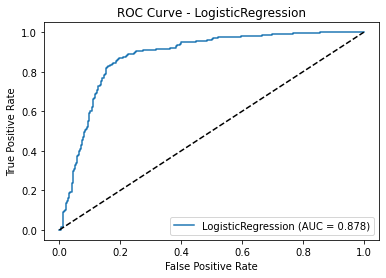

Running RandomForest
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best params for RandomForest:
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       780
           1       0.93      0.89      0.91       350

    accuracy                           0.94      1130
   macro avg       0.94      0.93      0.93      1130
weighted avg       0.94      0.94      0.94      1130

Test ROC AUC: 0.9908406593406593
Confusion matrix:
[[755  25]
 [ 39 311]]


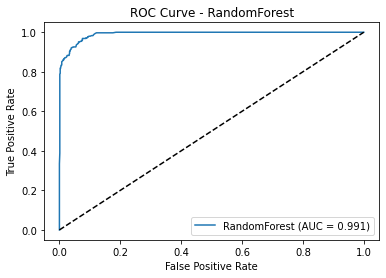

Running GradientBoosting
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__max_features': 'sqrt', 'clf__n_estimators': 300, 'clf__subsample': 1.0}
Best CV ROC AUC: 0.994

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       780
           1       0.92      0.90      0.91       350

    accuracy                           0.95      1130
   macro avg       0.94      0.93      0.94      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9920146520146521
Confusion matrix:
[[754  26]
 [ 34 316]]


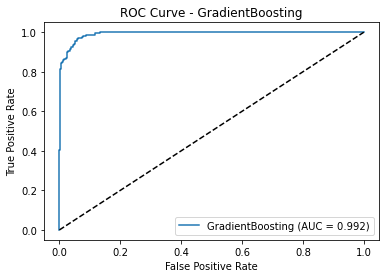

Running KNN
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params for KNN:
{'clf__metric': 'manhattan', 'clf__n_neighbors': 15, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.944

Test classification report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       780
           1       0.80      0.77      0.78       350

    accuracy                           0.87      1130
   macro avg       0.85      0.84      0.85      1130
weighted avg       0.87      0.87      0.87      1130

Test ROC AUC: 0.9409706959706959
Confusion matrix:
[[712  68]
 [ 80 270]]


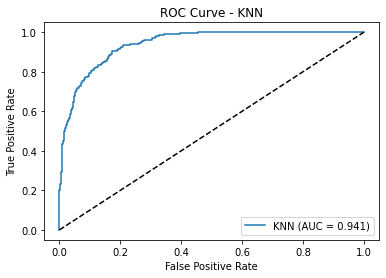

Running SVC
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [ ]:
# Only keep features that actually exist
feature_cols = [c for c in (base_features + course_features) if c in df.columns]
print("Using features:", feature_cols)

# Drop rows with missing label
df_model = df.dropna(subset=["VALUE_LABEL"])

X = df_model[feature_cols]
y = df_model["VALUE_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# -------------------------------------------------------------------
# 5. Location helper functions
# -------------------------------------------------------------------

def haversine_distance(lat1, lon1, lat2, lon2):
    """Great-circle distance between (lat1,lon1) and arrays (lat2,lon2) in km."""
    R = 6371.0  # Earth radius in km
    lat1_r = np.radians(lat1)
    lon1_r = np.radians(lon1)
    lat2_r = np.radians(lat2)
    lon2_r = np.radians(lon2)

    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r

    a = np.sin(dlat/2.0)**2 + np.cos(lat1_r)*np.cos(lat2_r)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def annotate_distance(df_in, user_lat, user_lon):
    """
    Add a DISTANCE_KM column to a copy of df_in, using user's home lat/lon.
    Requires LATITUDE, LONGITUDE columns.
    """
    df_loc = df_in.copy()
    if not {"LATITUDE", "LONGITUDE"} <= set(df_loc.columns):
        print("LATITUDE/LONGITUDE columns missing; returning dataframe unchanged.")
        return df_loc

    distances = haversine_distance(
        user_lat, user_lon,
        df_loc["LATITUDE"].values,
        df_loc["LONGITUDE"].values
    )
    df_loc["DISTANCE_KM"] = distances
    return df_loc

def filter_by_radius(df_in, user_lat, user_lon, radius_km):
    """Return only colleges within radius_km of the user."""
    df_with_dist = annotate_distance(df_in, user_lat, user_lon)
    if "DISTANCE_KM" not in df_with_dist.columns:
        return df_with_dist
    return df_with_dist[df_with_dist["DISTANCE_KM"] <= radius_km]

# -------------------------------------------------------------------
# 6. Multi-model classification with GridSearchCV
# -------------------------------------------------------------------

classifiers = {}

# 1. Logistic 



log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

# log_reg_param_grid = {
#     "clf__C": [0.01, 0.1, 1, 10],
#     "clf__class_weight": [None, "balanced"]
# }
log_reg_param_grid = [

    # L2 penalty
    {
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "saga"],
        "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
    },

    # L1 penalty
    {
        "clf__penalty": ["l1"],
        "clf__solver": ["liblinear", "saga"],
        "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
    },

    # ElasticNet (requires L1_ratio + saga)
    {
        "clf__penalty": ["elasticnet"],
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],
        "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
    }
]

classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_param_grid)

# 2. Random Forest
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])

# rf_param_grid = {
#     "clf__n_estimators": [200, 400],
#     "clf__max_depth": [None, 10, 20],
#     "clf__min_samples_split": [2, 5],
#     "clf__min_samples_leaf": [1, 2],
#     "clf__class_weight": [None, "balanced"]
# }
rf_param_grid = {
    "clf__n_estimators": [200, 400, 600],                 
    "clf__max_depth": [None, 10, 20, 30],                
    "clf__min_samples_split": [2, 5, 10],                
    "clf__min_samples_leaf": [1, 2, 4],                  
    "clf__max_features": ["sqrt", "log2"],               
    "clf__class_weight": [None, "balanced"]
}
classifiers["RandomForest"] = (rf_pipe, rf_param_grid)

# 3. Gradient Boosting
gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# gb_param_grid = {
#     "clf__n_estimators": [100, 200],
#     "clf__learning_rate": [0.01, 0.1],
#     "clf__max_depth": [3, 5]
# }
gb_param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [1.0, 0.8],
    "clf__max_features": ["sqrt", "log2"]
}

classifiers["GradientBoosting"] = (gb_pipe, gb_param_grid)

# 4. KNN
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

# knn_param_grid = {
#     "clf__n_neighbors": [5, 15, 25],
#     "clf__weights": ["uniform", "distance"]
# }
knn_param_grid = {
    "clf__n_neighbors": [3, 5, 11, 15, 21, 25],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "manhattan"]
}

classifiers["KNN"] = (knn_pipe, knn_param_grid)

# 5. Support Vector Classifier
svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

# svc_param_grid = {
#     "clf__C": [0.1, 1, 10],
#     "clf__gamma": ["scale", "auto"],
#     "clf__kernel": ["rbf", "linear"],
#     "clf__class_weight": [None, "balanced"]
# }
svc_param_grid = {
    "clf__C": [0.1, 1, 5, 10, 20],
    "clf__gamma": ["scale", "auto", 0.01, 0.001],
    "clf__kernel": ["rbf", "linear", "poly"],
    "clf__degree": [2, 3],
    "clf__class_weight": [None, "balanced"]
}

classifiers["SVC"] = (svc_pipe, svc_param_grid)



best_classifiers = {}
cv_results_dict = {}
test_metrics = {}
cv_best_scores = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_classifiers[name] = best_model

    # Save cv results for later plots
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_dict[name] = cv_results

    # Test set evaluation
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("\nTest classification report:")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print("Test ROC AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    test_metrics[name] = {"roc_auc": auc}

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Choose main model for ranking using CV ROC AUC (keep test set as blind check)
best_model_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_model_name]
print(
    f"Selected main value model: {best_model_name} "
    f"(CV ROC AUC = {cv_best_scores[best_model_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_model_name]['roc_auc']:.3f})"
)

# -------------------------------------------------------------------
# 7. Plot CV performance for each model (hyperparameter combos)
# -------------------------------------------------------------------

def plot_cv_performance(cv_results, model_name, top_n=15):
    """
    Plot mean CV score for the top_n hyperparameter combinations.
    Each bar corresponds to one 'params' setting in cv_results_.
    """
    df_cv = cv_results.copy()
    df_cv = df_cv.sort_values("mean_test_score", ascending=False).head(top_n)

    plt.figure(figsize=(8, 4 + top_n * 0.15))
    sns.barplot(
        data=df_cv,
        x="mean_test_score",
        y=df_cv.index.astype(str),
        orient="h"
    )
    plt.xlabel("Mean CV ROC AUC")
    plt.ylabel("Hyperparameter setting (index)")
    plt.title(f"Top {top_n} CV results - {model_name}")
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} hyperparameter settings for {model_name}:")
    display(df_cv[["mean_test_score", "std_test_score", "params"]])

for name, cv_res in cv_results_dict.items():
    plot_cv_performance(cv_res, name, top_n=10)

# Compare final test ROC AUC across models
plt.figure(figsize=(6, 4))
names = list(test_metrics.keys())
scores = [test_metrics[m]["roc_auc"] for m in names]
sns.barplot(x=names, y=scores)
plt.ylabel("Test ROC AUC")
plt.title("Model comparison on test set")
plt.show()

# -------------------------------------------------------------------
# 8. Ranking function with user weights (course-level + location)
# -------------------------------------------------------------------

def minmax_series(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

def rank_colleges_for_user(
    df_raw,
    feature_cols,
    value_model,
    user_weights,
    user_lat=None,
    user_lon=None,
    radius_km=None
):
    """
    user_weights example:
        {
          "value_model": 5,
          "cost": 5,
          "engineering": 4,
          "debt": 3,
          "location": 2,
          "program_count": 2,
          "prefer_public": 3,
          "prefer_private": 0
        }
    If user_lat, user_lon, radius_km are provided, will filter to those within radius.
    """
    df_scored = df_raw.copy()

    # Apply location filter if requested
    if (user_lat is not None) and (user_lon is not None) and (radius_km is not None):
        df_scored = filter_by_radius(df_scored, user_lat, user_lon, radius_km)

    # Model-based probability of being "high-value"
    X_all = df_scored[feature_cols]
    p_value = value_model.predict_proba(X_all)[:, 1]
    df_scored["p_value_model"] = p_value

    # Cost score (lower cost -> higher score)
    df_scored["cost_score"] = 1 - minmax_series(df_scored["COSTT4_A"])

    # Engineering intensity
    df_scored["eng_score"] = minmax_series(df_scored["ENG_RATIO"])

    # Debt score from course-level aggregates (lower debt -> higher score)
    debt_cols_present = [c for c in df_scored.columns if "DEBT_ALL_STGP_ANY_MDN" in c]
    if len(debt_cols_present) > 0:
        debt_raw = df_scored[debt_cols_present].mean(axis=1)
        df_scored["debt_score"] = 1 - minmax_series(debt_raw)
    else:
        df_scored["debt_score"] = 0.5

    # Program count (more engineering programs may be good)
    if "ENG_PROG_COUNT" in df_scored.columns:
        df_scored["prog_count_score"] = minmax_series(df_scored["ENG_PROG_COUNT"])
    else:
        df_scored["prog_count_score"] = 0.5

    # Location score: closer is better (if distance available)
    if "DISTANCE_KM" in df_scored.columns:
        df_scored["location_score"] = 1 - minmax_series(df_scored["DISTANCE_KM"])
    else:
        df_scored["location_score"] = 0.5

    # Sector (public / private)
    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        sector_indicator = np.full(len(df_scored), 0.5)
    df_scored["sector_indicator"] = sector_indicator

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        df_scored["SECTOR"] = np.select(
            [
                df_scored["IS_PUBLIC"] == 1,
                df_scored["IS_PRIVATE"] == 1,
                df_scored["IS_FORPROFIT"] == 1
            ],
            ["Public", "Private", "For-profit"],
            default="Other"
        )
    else:
        df_scored["SECTOR"] = "Unknown"

    # Weights
    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_debt    = user_weights.get("debt", 0)
    w_loc     = user_weights.get("location", 0)
    w_prog    = user_weights.get("program_count", 0)
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)

    # Sector preference component
    sector_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    total_w = (
        w_value + w_cost + w_eng + w_debt + w_loc + w_prog +
        w_public + w_private
    )
    if total_w == 0:
        raise ValueError("All user weights are zero!")

    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_debt  * df_scored["debt_score"] +
        w_loc   * df_scored["location_score"] +
        w_prog  * df_scored["prog_count_score"] +
        sector_component
    ) / total_w

    cols_to_show = [
        "INSTNM", "CITY", "STABBR", "SECTOR",
        "COSTT4_A", "ENG_RATIO", "ENG_PROG_COUNT",
        "p_value_model", "USER_SCORE"
    ]
    cols_to_show = [c for c in cols_to_show if c in df_scored.columns]

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    return ranked[cols_to_show]

# -------------------------------------------------------------------
# 9. Example usage for ranking
# -------------------------------------------------------------------

example_weights = {
    "value_model": 5,
    "cost": 5,
    "engineering": 4,
    "debt": 3,
    "location": 2,
    "program_count": 2,
    "prefer_public": 3,
    "prefer_private": 0
}

# Example user location (Gainesville, FL-ish) and radius
user_lat_example = 29.6516
user_lon_example = -82.3248
radius_km_example = 300

ranked_colleges = rank_colleges_for_user(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=example_weights,
    user_lat=user_lat_example,
    user_lon=user_lon_example,
    radius_km=radius_km_example
)

ranked_colleges.head(20)


